In [1]:
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.kid import KernelInceptionDistance
import torch
from tqdm import tqdm

In [3]:
data_dir = '/mnt/g/visuals_from_server/512-64-700-test'

In [4]:
real_images = torch.load(f'{data_dir}/celeba_test_real_images_2.pt')
synthetic_images = torch.load(f'{data_dir}/celeba_test_images_2.pt')

real_images = (real_images + 1) / 2

# convert them to 0-255 uint8
real_images = (real_images * 255).type(torch.uint8)
synthetic_images = (synthetic_images * 255).type(torch.uint8)

# save the images
torch.save(real_images, f'{data_dir}/celeba_test_real_images_2_uint8.pt')
torch.save(synthetic_images, f'{data_dir}/celeba_test_images_2_uint8.pt')

In [3]:
fid = FrechetInceptionDistance(feature=2048, normalize=False)
kid = KernelInceptionDistance(feature=2048, normalize=False, subset_size = 60)

/home/mate/miniconda3/envs/stable_diffusion/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `Kernel Inception Distance` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


In [4]:
real_images = torch.load(f'{data_dir}/celeba_test_real_images_1_uint8.pt')
synthetic_images = torch.load(f'{data_dir}/celeba_test_images_1_uint8.pt')

real_images_2 = torch.load(f'{data_dir}/celeba_test_real_images_2_uint8.pt')
synthetic_images_2 = torch.load(f'{data_dir}/celeba_test_images_2_uint8.pt')

In [5]:
# concatenate the two sets of images
real_images = torch.cat((real_images, real_images_2))
synthetic_images = torch.cat((synthetic_images, synthetic_images_2))

In [6]:
print(real_images.shape)
print(synthetic_images.shape)

torch.Size([2400, 3, 512, 512])
torch.Size([2400, 3, 512, 512])


In [7]:
print(min(real_images[0].flatten()), max(real_images[0].flatten()))
print(min(real_images_2[0].flatten()), max(real_images_2[0].flatten()))

tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)
tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)


In [11]:
batch_size = 64

# update with real images in batch sizes
for i in tqdm(range(0, len(real_images), batch_size)):
    real_batch = real_images[i:i+batch_size]
    fid.update(real_batch, real=True)
    kid.update(real_batch, real=True)

# update with synthetic images in batch sizes
for i in tqdm(range(0, len(synthetic_images), batch_size)):
    synthetic_batch = synthetic_images[i:i+batch_size]
    fid.update(synthetic_batch, real=False)
    kid.update(synthetic_batch, real=False)




100%|██████████| 38/38 [02:30<00:00,  3.96s/it]


In [12]:
fid_score = fid.compute()
kid_score = kid.compute()

In [13]:
print(f"FrechetInceptionDistance: {fid_score}")
print(f"KernelInceptionDistance: {kid_score}")

FrechetInceptionDistance: 25.26197052001953
KernelInceptionDistance: (tensor(0.0097), tensor(0.0030))


In [10]:
sample_sizes = [300, 600, 900, 1200, 1500, 1800, 2100, 2400]
fid_scores = []
kid_scores = []
batch_size = 64

In [11]:
for sample_size in sample_sizes:
    used_real_images = real_images[:sample_size]
    used_synthetic_images = synthetic_images[:sample_size]

    fid = FrechetInceptionDistance(feature=2048, normalize=False)
    kid = KernelInceptionDistance(feature=2048, normalize=False, subset_size = 60)

    # update with real images in batch sizes
    for i in tqdm(range(0, len(used_real_images), batch_size)):
        real_batch = used_real_images[i:i+batch_size]
        fid.update(real_batch, real=True)
        kid.update(real_batch, real=True)

    # update with synthetic images in batch sizes
    for i in tqdm(range(0, len(used_synthetic_images), batch_size)):
        synthetic_batch = used_synthetic_images[i:i+batch_size]
        fid.update(synthetic_batch, real=False)
        kid.update(synthetic_batch, real=False)

    fid_score = fid.compute()
    kid_score = kid.compute()

    fid_scores.append(fid_score)
    kid_scores.append(kid_score)

print(fid_scores)
print(kid_scores)

100%|██████████| 38/38 [02:32<00:00,  4.02s/it]


[tensor(58.8891), tensor(45.1758), tensor(37.9520), tensor(33.1345), tensor(30.7186), tensor(28.5493), tensor(26.7188), tensor(25.2620)]
[(tensor(0.0101), tensor(0.0026)), (tensor(0.0113), tensor(0.0027)), (tensor(0.0111), tensor(0.0031)), (tensor(0.0105), tensor(0.0028)), (tensor(0.0100), tensor(0.0022)), (tensor(0.0102), tensor(0.0033)), (tensor(0.0101), tensor(0.0028)), (tensor(0.0098), tensor(0.0028))]


In [27]:
# save the scores
torch.save(fid_scores, f'{data_dir}/fid_scores.pt')
torch.save(kid_scores, f'{data_dir}/kid_scores.pt')

In [4]:
fid_scores = torch.load(f'{data_dir}/fid_scores.pt')
kid_scores = torch.load(f'{data_dir}/kid_scores.pt')

In [6]:
sample_sizes = [300, 600, 900, 1200, 1500, 1800, 2100, 2400]

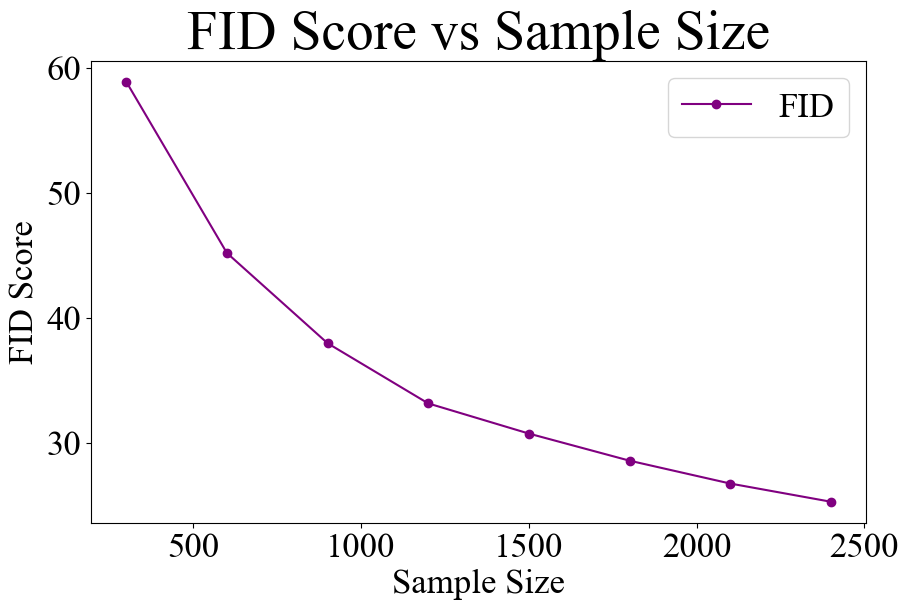

In [12]:
from matplotlib import pyplot as plt
# change font to times new roman
plt.rcParams["font.family"] = "Times New Roman"

# change plot size
plt.rcParams["figure.figsize"] = (10, 6)

# change font size on axis
plt.rcParams.update({'font.size': 25})


plt.plot(sample_sizes, fid_scores, label='FID', marker='o', color='purple')
# add axis labels
plt.xlabel('Sample Size', fontsize=25)
plt.ylabel('FID Score', fontsize=25)
plt.title('FID Score vs Sample Size', fontsize=40)

plt.legend()
plt.show()


In [8]:
# transform kid scores to numpy array
kid_scores = torch.tensor(kid_scores).numpy()

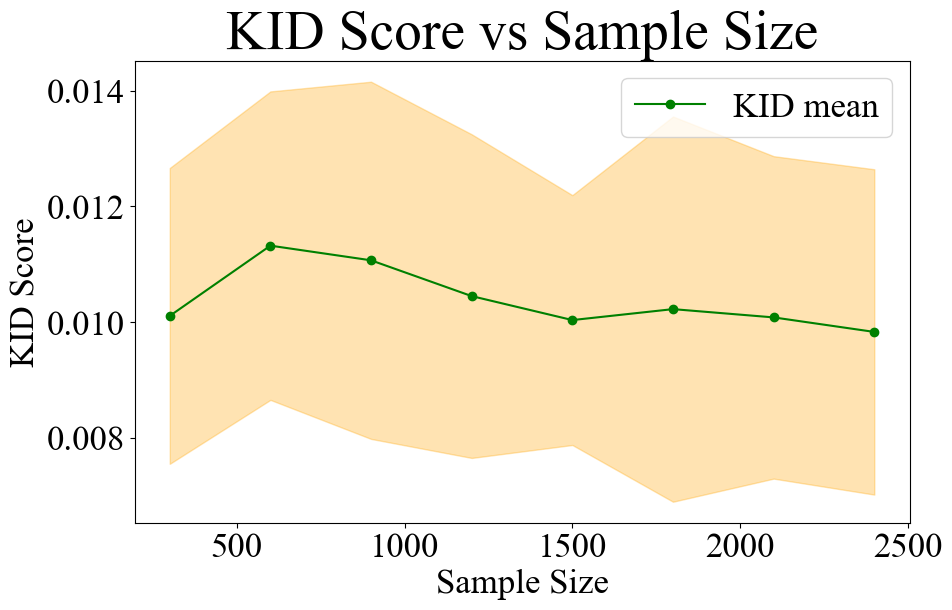

In [13]:
# plot the kid scores
plt.plot(sample_sizes, kid_scores[:, 0], label='KID mean', marker='o', color='green')
#plt.plot(sample_sizes, kid_scores[:, 1], label='KID std', marker='o', color='orange')
# plot std as fill between
plt.fill_between(sample_sizes, kid_scores[:, 0] - kid_scores[:, 1], kid_scores[:, 0] + kid_scores[:, 1], color='orange', alpha=0.3)
# add axis labels
plt.xlabel('Sample Size', fontsize=25)
plt.ylabel('KID Score', fontsize=25)
plt.title('KID Score vs Sample Size', fontsize=40)

plt.legend()
plt.show()